# Questions to Answer
- **Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?**

    - perform a statistical test to get a mathematically-supported answer.
    - report if you found a significant difference between ratings
        - If so, what was the p-value of your analysis?
        - And which rating earns the most revenue?
    - prepare a visualization that supports your finding.
    

- **Think of 2 additional hypotheses to test 
that your stakeholder may want to know.**
- Some example hypotheses you could test:
    - Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?
    - Do movies released in 2020 earn less revenue than movies released in 2018?
        - How do the years compare for movie ratings?
    - Do some movie genres earn more revenue than others?
    - Are some genres higher rated than others?

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kruskal
import json
import pymysql
import glob
from statsmodels.stats.multicomp import pairwise_tukeyhsd
pd.set_option('display.max_columns', None)

# Load Data

## Get movie data from 2010-2019

In [2]:
# Run search query to load all title_basics files for 2010-2019
q="C:\\Users\\Chris Palisoc\\Documents\\Coding Dojo\\Coding Dojo Project 3\\Project3\\Data\\Part 4 Data\\final_tmdb_data*.csv.gz"
chunked_files = sorted(glob.glob(q))
# show sorted first 5 files
chunked_files[:5]

['C:\\Users\\Chris Palisoc\\Documents\\Coding Dojo\\Coding Dojo Project 3\\Project3\\Data\\Part 4 Data\\final_tmdb_data_2010.csv.gz',
 'C:\\Users\\Chris Palisoc\\Documents\\Coding Dojo\\Coding Dojo Project 3\\Project3\\Data\\Part 4 Data\\final_tmdb_data_2011.csv.gz',
 'C:\\Users\\Chris Palisoc\\Documents\\Coding Dojo\\Coding Dojo Project 3\\Project3\\Data\\Part 4 Data\\final_tmdb_data_2012.csv.gz',
 'C:\\Users\\Chris Palisoc\\Documents\\Coding Dojo\\Coding Dojo Project 3\\Project3\\Data\\Part 4 Data\\final_tmdb_data_2013.csv.gz',
 'C:\\Users\\Chris Palisoc\\Documents\\Coding Dojo\\Coding Dojo Project 3\\Project3\\Data\\Part 4 Data\\final_tmdb_data_2014.csv.gz']

In [3]:
# combine 2010-2019 into one df using for loop
## load all files as df appending to list
df_list = []
for file in chunked_files:
    temp_df = pd.read_csv(file, lineterminator='\n')
    df_list.append(temp_df)
## concatenate list of df's into 1 big one
df = pd.concat(df_list)
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
2,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
3,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
4,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4672,tt9906644,0.0,/htoReVItKtolso5VJqFqJDBaOwm.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,635903.0,ml,മനോഹരം,Manoharan is a poster artist struggling to fin...,1.309,/cNWfJlveyMEbiORrKmFKZZRDx75.jpg,"[{'id': 125107, 'logo_path': None, 'name': 'Ch...","[{'iso_3166_1': 'IN', 'name': 'India'}]",2019-09-27,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,Beautiful,Manoharam,0.0,6.2,10.0,NaN
4673,tt9913660,0.0,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,When a group of women struggle to deal with th...,0.646,/fqIWD97MAjgrj8mB2M78kxeSSnk.jpg,[],[],2019-10-23,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.0,1.0,NaN
4674,tt9913936,0.0,/i4moNlJn4EpSE5auFeoeIae366g.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,594570.0,sv,Paradise,Diego hoped to never loose his friends after h...,0.756,/fJFCcueSi7u7OgVQhiDtKsXc8cS.jpg,"[{'id': 69920, 'logo_path': None, 'name': 'DEP...","[{'iso_3166_1': 'SE', 'name': 'Sweden'}]",2019-10-25,0.0,135.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,NaN,Paradise,0.0,8.5,2.0,NaN
4675,tt9914942,0.0,/tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,598553.0,ca,La vida sense la Sara Amat,"Pep, a 13-year-old boy, is in love with a girl...",2.901,/ulCLv5kRiC8JnxdRBczDzx0NjSr.jpg,"[{'id': 20786, 'logo_path': None, 'name': ""Mas...","[{'iso_3166_1': 'ES', 'name': 'Spain'}]",2019-07-12,0.0,74.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Released,NaN,Life without Sara Amat,0.0,7.8,6.0,NaN


# Preprocessing

In [4]:
# remove ids that are 0
df = df.loc[df['imdb_id']!='0']
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
1,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
2,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
3,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
4,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
5,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4672,tt9906644,0.0,/htoReVItKtolso5VJqFqJDBaOwm.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,635903.0,ml,മനോഹരം,Manoharan is a poster artist struggling to fin...,1.309,/cNWfJlveyMEbiORrKmFKZZRDx75.jpg,"[{'id': 125107, 'logo_path': None, 'name': 'Ch...","[{'iso_3166_1': 'IN', 'name': 'India'}]",2019-09-27,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,Beautiful,Manoharam,0.0,6.2,10.0,NaN
4673,tt9913660,0.0,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,When a group of women struggle to deal with th...,0.646,/fqIWD97MAjgrj8mB2M78kxeSSnk.jpg,[],[],2019-10-23,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.0,1.0,NaN
4674,tt9913936,0.0,/i4moNlJn4EpSE5auFeoeIae366g.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,594570.0,sv,Paradise,Diego hoped to never loose his friends after h...,0.756,/fJFCcueSi7u7OgVQhiDtKsXc8cS.jpg,"[{'id': 69920, 'logo_path': None, 'name': 'DEP...","[{'iso_3166_1': 'SE', 'name': 'Sweden'}]",2019-10-25,0.0,135.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,NaN,Paradise,0.0,8.5,2.0,NaN
4675,tt9914942,0.0,/tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,598553.0,ca,La vida sense la Sara Amat,"Pep, a 13-year-old boy, is in love with a girl...",2.901,/ulCLv5kRiC8JnxdRBczDzx0NjSr.jpg,"

In [5]:
df.reset_index(drop=True)
df.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
1,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
2,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
3,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
4,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
5,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG


In [6]:
# drop unnecessary columns
drop_cols = ['backdrop_path','backdrop_path', 'overview',
                 'poster_path','status','tagline','id','homepage',
                 'production_countries','video','production_companies',
            'original_language']
df = df.drop(columns=drop_cols)
df.head()

,imdb_id,adult,belongs_to_collection,budget,genres,original_title,popularity,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,certification
1,tt0312305,0.0,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",Quantum Quest: A Cassini Space Odyssey,2.769,2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN
2,tt0326965,0.0,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",In My Sleep,6.120,2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",In My Sleep,5.5,31.0,PG-13
3,tt0331312,0.0,NaN,0.0,[],This Wretched Life,0.600,2010-01-01,0.0,0.0,[],This Wretched Life,5.0,1.0,NaN
4,tt0393049,0.0,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Anderson's Cross,2.418,2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Anderson's Cross,4.0,5.0,NaN
5,tt0398286,0.0,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",Tangled,119.168,2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Tangled,7.6,9364.0,PG


# Feature Engineering

## Convert 'belongs_to_collection' to bool

In [7]:
# show how many movies belong to a collection or not
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    34619
True      2223
Name: belongs_to_collection, dtype: int64

## Separate genres

In [8]:
## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [9]:
# Use function and explode the new column
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')
df_explode

,imdb_id,adult,belongs_to_collection,budget,genres,original_title,popularity,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,certification,genres_list
1,tt0312305,0.0,False,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",Quantum Quest: A Cassini Space Odyssey,2.769,2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,Family
1,tt0312305,0.0,False,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",Quantum Quest: A Cassini Space Odyssey,2.769,2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,Animation
1,tt0312305,0.0,False,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",Quantum Quest: A Cassini Space Odyssey,2.769,2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,Science Fiction
2,tt0326965,0.0,False,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",In My Sleep,6.120,2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",In My Sleep,5.5,31.0,PG-13,Thriller
2,tt0326965,0.0,False,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",In My Sleep,6.120,2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",In My Sleep,5.5,31.0,PG-13,Mystery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4674,tt9913936,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",Paradise,0.756,2019-10-25,0.0,135.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Paradise,8.5,2.0,NaN,Drama
4674,tt9913936,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",Paradise,0.756,2019-10-25,0.0,135.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Paradise,8.5,2.0,NaN,Crime
4675,tt9914942,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",La vida sense la Sara Amat,2.901,2019-07-12,0.0,74.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Life without Sara Amat,7.8,6.0,NaN,Drama
4675,tt9914942,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",La vida sense la Sara Amat,2.901,2019-07-12,0.0,74.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Life without Sara Amat,7.8,6.0,NaN,Romance


In [10]:
# save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()
unique_genres

array(['Family', 'Animation', 'Science Fiction', 'Thriller', 'Mystery',
       'Drama', 'Romance', 'Comedy', 'War', 'Crime', 'Action',
       'Adventure', 'Horror', 'Fantasy', 'History', 'Western', 'Music',
       'Documentary', 'TV Movie'], dtype=object)

In [11]:
# Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)    
df

,imdb_id,adult,belongs_to_collection,budget,genres,original_title,popularity,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,certification,genres_list,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie
1,tt0312305,0.0,False,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",Quantum Quest: A Cassini Space Odyssey,2.769,2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,"[Family, Animation, Science Fiction]",True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,tt0326965,0.0,False,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",In My Sleep,6.120,2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",In My Sleep,5.5,31.0,PG-13,"[Thriller, Mystery, Drama]",False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,tt0331312,0.0,False,0.0,[],This Wretched Life,0.600,2010-01-01,0.0,0.0,[],This Wretched Life,5.0,1.0,NaN,[],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,tt0393049,0.0,False,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Anderson's Cross,2.418,2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Anderson's Cross,4.0,5.0,NaN,"[Romance, Comedy, Drama]",False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
5,tt0398286,0.0,False,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",Tangled,119.168,2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Tangled,7.6,9364.0,PG,"[Animation, Family]",True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4672,tt9906644,0.0,False,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",മനോഹരം,1.309,2019-09-27,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Manoharam,6.2,10.0,NaN,"[Comedy, Drama]",False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False
4673,tt9913660,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",No Apology,0.646,2019-10-23,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",No Apology,8.0,1.0,NaN,[Drama],False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4674,tt9913936,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",Paradise,0.756,2019-10-25,0.0,135.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Paradise,8.5,2.0,NaN,"[Drama, Crime]",False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False
4675,tt9914942,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",La vida sense la Sara Amat,2.901,2019-07-12,0.0,74.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Life without Sara Amat,7.8,6.0,NaN,"[Drama, Romance]",False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False


In [12]:
# Drop original genre columns
df = df.drop(columns=['genres','genres_list'])
df.head(2)

,imdb_id,adult,belongs_to_collection,budget,original_title,popularity,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie
1,tt0312305,0.0,False,0.0,Quantum Quest: A Cassini Space Odyssey,2.769,2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,tt0326965,0.0,False,0.0,In My Sleep,6.120,2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False


## clean 'certification' column

In [13]:
# check 'certification' values
df['certification'].value_counts()

R          3071
NR         2178
PG-13      1730
PG          786
G           268
NC-17        99
Unrated       4
R             1
PG-13         1
10            1
Name: certification, dtype: int64

In [14]:
df['certification'].value_counts(dropna=False)

NaN        28703
R           3071
NR          2178
PG-13       1730
PG           786
G            268
NC-17         99
Unrated        4
R              1
PG-13          1
10             1
Name: certification, dtype: int64

In [15]:
# fix extra space certs
df['certification'] = df['certification'].str.strip()

In [16]:
# fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)

NaN      28704
R         3072
NR        2182
PG-13     1731
PG         786
G          268
NC-17       99
Name: certification, dtype: int64

# Does the MPAA rating of a movie affect how much revenue the movie generates?

## Null and Alternative hypothesis
- **Null Hypothesis:** The MPAA rating of a movie does not make a difference in the revenue that the movie makes.

- **Alternative Hypothesis:** There is a significant difference in the revenue a movie makes based on MPAA rating.

- significance value (alpha) = .05

## Choose the appropriate hypothesis test
Since the question is asking about several MPAA ratings, we will conduct Tukey's Pairwise Multiple Comparisons Test.

In [17]:
# preview dataframe
df.head()

,imdb_id,adult,belongs_to_collection,budget,original_title,popularity,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie
1,tt0312305,0.0,False,0.0,Quantum Quest: A Cassini Space Odyssey,2.769,2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,tt0326965,0.0,False,0.0,In My Sleep,6.120,2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,tt0331312,0.0,False,0.0,This Wretched Life,0.600,2010-01-01,0.0,0.0,[],This Wretched Life,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,tt0393049,0.0,False,300000.0,Anderson's Cross,2.418,2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Anderson's Cross,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
5,tt0398286,0.0,False,260000000.0,Tangled,119.168,2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Text(0.5, 1.0, 'Revenue by MPAA Rating')

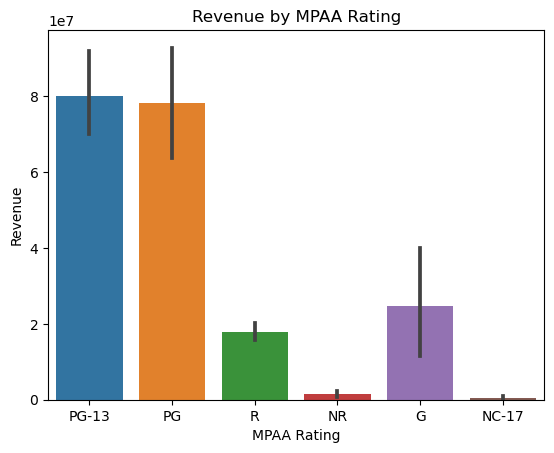

In [18]:
# plot revenues by MPAA rating
sns.barplot(data=df, x='certification',y='revenue')
plt.xlabel('MPAA Rating')
plt.ylabel('Revenue')
plt.title('Revenue by MPAA Rating')

As shown in the plot above, it seems that there is a difference between the ratings based on revenue, but we'll proceed with the ANOVA test to determine that.

In [19]:
# Create groups dictionary for the MPAA ratings
groups = {}
# Loop through all the ratings
for i in df['certification'].unique():
    # Get series for group and rename
    data = df.loc[df['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys([nan, 'PG-13', 'PG', 'R', 'NR', 'G', 'NC-17'])

## Testing Assumption of Normality

In [20]:
# Running normal test on each rating and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    if len(data) < 8:  # check if data has less than 8 samples
        norm_results[i] = {'n': len(data),
                           'p': np.nan,
                           'test stat': np.nan,
                           'skew': np.nan,
                           'kurtosis': np.nan}
        continue  # skip this iteration and move on to next iteration
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                       'p': p,
                       'test stat': stat,
                       'skew': stats.skew(data),
                       'kurtosis': stats.kurtosis(data)}

In [21]:
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat,skew,kurtosis
NaN,0.0,NaN,NaN,NaN,NaN
PG-13,1731.0,0.000000e+00,1732.761956,4.870549,32.518901
PG,786.0,2.372613e-143,656.811353,3.850437,17.435767
R,3072.0,0.000000e+00,3825.414512,6.742701,63.859679
NR,2182.0,0.000000e+00,5016.545820,21.613364,603.755055
G,268.0,2.083651e-80,366.945372,6.547297,46.803581
NC-17,99.0,9.457462e-32,142.871838,5.352315,28.369002


Since out p-values < .05, our data is not normally distributed, but our sample sizes for both groups are large enough to continue with the test.

## Testing Assumption of equal variance

In [22]:
# use Levene test
stats.levene(groups['PG-13'],
            groups['PG'],
            groups['R'],
            groups['NR'],
            groups['G'],
            groups['NC-17'])


LeveneResult(statistic=104.693228103117, pvalue=2.0169117697808348e-107)

Since the p-value < .05 from our levene result, we do not have equal variance.

## Kruskal-Wallis test

In [23]:
# since we failed the levene test, we run the Kruskal-Wallis test
result = stats.kruskal(groups['PG-13'],
            groups['PG'],
            groups['R'],
            groups['NR'],
            groups['G'],
            groups['NC-17'])
result

KruskalResult(statistic=1098.2315002317162, pvalue=3.229276673064315e-235)

The overall results show that there is a significan difference in the revenues based on MPAA ratings and with the Kruskal-Wallis test, the p-value is less than our alpha of .05. Comparing these results to the barplot previously confirms Kruskal-Wallis test and we can reject the null hypothesis.

Per the bar plot, out of all the ratings, PG-13 brings in the most revenue.

# Are movies that belong to a collection more popular than movies that don't belong to a collection?

### Null and Alternative Hypothesis
 - Null Hypothesis: There is no difference in the polularity between movies that belong in a collection and those that don't belong in a collection
 
 - Alternative Hypothesis: There a significant difference in the popularity between movies that belong in a collection than those that don't.
 
 - significance value (alpha) = .05

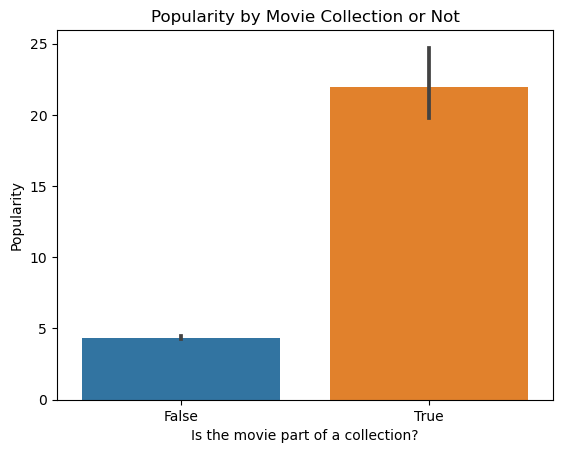

In [24]:
# plot popularity by collections
sns.barplot(data=df, x='belongs_to_collection',y='popularity')
plt.xlabel('Is the movie part of a collection?')
plt.ylabel('Popularity')
plt.title('Popularity by Movie Collection or Not')
plt.ticklabel_format(style='plain', axis='y');

Using the eye test alone, the bar plot depicts a big difference in polularity of a movie based on whether it is part of a collection or not. We will confirm this by performing a 2-sample t-test.

## Group the data

In [25]:
# filter out collection movies
collection_filter = df['belongs_to_collection'] == True
collection_df = df[collection_filter]
collection = collection_df['popularity']
collection.info()
collection.head()

<class 'pandas.core.series.Series'>
Int64Index: 2223 entries, 6 to 4667
Series name: popularity
Non-Null Count  Dtype  
--------------  -----  
2223 non-null   float64
dtypes: float64(1)
memory usage: 34.7 KB


6      4.554
7     70.694
12    93.983
23    48.675
47    89.590
Name: popularity, dtype: float64

In [26]:
# filter out non-collection movies
noncollection_filter = df['belongs_to_collection'] == False
noncollection_df = df[noncollection_filter]
noncollection = noncollection_df['popularity']
noncollection.info()
noncollection.head()

<class 'pandas.core.series.Series'>
Int64Index: 34619 entries, 1 to 4676
Series name: popularity
Non-Null Count  Dtype  
--------------  -----  
34619 non-null  float64
dtypes: float64(1)
memory usage: 540.9 KB


1      2.769
2      6.120
3      0.600
4      2.418
5    119.168
Name: popularity, dtype: float64

## Check/remove outliers

In [27]:
# check for outliers in collection group
zscores= stats.zscore(collection)
outliers = abs(zscores)>3
np.sum(outliers)

10

In [28]:
# remove outliers from collection group
collection = collection[(np.abs(stats.zscore(collection)) < 3)]

In [29]:
# check for outliers in non-collection group
zscores= stats.zscore(noncollection)
outliers = abs(zscores)>3
np.sum(outliers)

551

In [30]:
# remove outliers from non-collection group
noncollection = noncollection[(np.abs(stats.zscore(noncollection)) < 3)]

## Check for normality

In [31]:
# test collection group for normality
result_collection = stats.normaltest(collection)
result_collection

NormaltestResult(statistic=1347.8860329349877, pvalue=2.0429927758137165e-293)

In [32]:
# test non-collection group for normality
result_noncollection = stats.normaltest(noncollection)
result_noncollection

NormaltestResult(statistic=19518.64124858525, pvalue=0.0)

Since out p-values < .05, our data is not normally distributed, but our sample sizes for both groups are large enough to continue with the test.

## Test for equal vairance

In [33]:
# Test for equal variance
result = stats.levene(collection, noncollection)
result

LeveneResult(statistic=5792.54140852659, pvalue=0.0)

Since the p-value < .05 from our levene result, we do not have equal variance. This will be specified in the t-test

## 2-sample t-test

In [34]:
# t-test with equal_var set to False
result = stats.ttest_ind(collection, noncollection, equal_var = False)
result

Ttest_indResult(statistic=23.863302063378775, pvalue=3.2432966180925253e-112)

Since our p-value is < .05 (alpha), we reject the null hypothesis and accept that there is a significant difference in the popularity between movies that belong to a collection and those that don't belong to a collection. This conclusion further affirms the results in the barplot.

# Do bigger budget films (>$10Million) have higher average votes than films with a lesser budget?

## Null and Alternative Hypothesis
 - Null Hypothesis: There is no difference in the average votes between high-budget movies and low-budget movies
 
 - Alternative Hypothesis: There a significant difference in the average votes between high-budget movies and low-budget movies
 
 - significance value (alpha) = .05

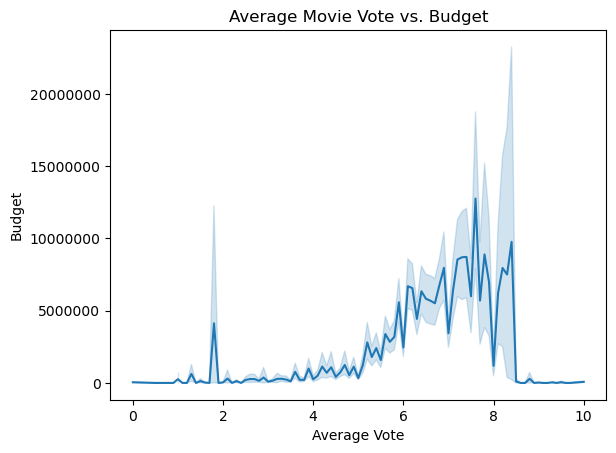

In [35]:
# plot vote average by budget
sns.lineplot(data=df, x='vote_average',y='budget')
plt.xlabel('Average Vote')
plt.ylabel('Budget')
plt.title('Average Movie Vote vs. Budget');
plt.ticklabel_format(style='plain', axis='y');

Based on the graphic above, it isn't explicitly clear whether higher budget films have higher average votes that films with a lesser budget. We will determine this with a 2-sample t-test.

## Group the data

In [36]:
# filter out big budget movies
bigbudget_filter = df['budget'] > 10000000
bigbudget_df = df[bigbudget_filter]
bigbudget = bigbudget_df['vote_average']
bigbudget.info()
bigbudget.head()

<class 'pandas.core.series.Series'>
Int64Index: 1731 entries, 5 to 4513
Series name: vote_average
Non-Null Count  Dtype  
--------------  -----  
1731 non-null   float64
dtypes: float64(1)
memory usage: 27.0 KB


5     7.6
6     5.1
7     5.4
10    5.6
11    6.4
Name: vote_average, dtype: float64

In [37]:
# filter out big budget movies
lowbudget_filter = df['budget'] < 10000000
lowbudget_df = df[lowbudget_filter]
lowbudget = lowbudget_df['vote_average']
lowbudget.info()
lowbudget.head()

<class 'pandas.core.series.Series'>
Int64Index: 34944 entries, 1 to 4676
Series name: vote_average
Non-Null Count  Dtype  
--------------  -----  
34944 non-null  float64
dtypes: float64(1)
memory usage: 546.0 KB


1    8.4
2    5.5
3    5.0
4    4.0
8    5.5
Name: vote_average, dtype: float64

## Check/remove outliers

In [38]:
# check for outliers in bigbudget group
zscores= stats.zscore(bigbudget)
outliers = abs(zscores)>3
np.sum(outliers)

11

In [39]:
# check for outliers in lowbudget group
zscores= stats.zscore(lowbudget)
outliers = abs(zscores)>3
np.sum(outliers)

0

In [40]:
# remove outliers from bigbudget group
bigbudget = bigbudget[(np.abs(stats.zscore(bigbudget)) < 3)]

## Check for normality

In [41]:
# test bigbudget group for normality
result_bigbudget = stats.normaltest(bigbudget)
result_bigbudget

NormaltestResult(statistic=8.060015132686944, pvalue=0.017774195467482812)

In [42]:
# test lowbudget group for normality
result_lowbudget = stats.normaltest(lowbudget)
result_lowbudget

NormaltestResult(statistic=3758.7334217949574, pvalue=0.0)

Since out p-values < .05, our data is not normally distributed, but our sample sizes for both groups are large enough to continue with the test.

## Test for equal variance

In [43]:
# Test for equal variance
result = stats.levene(bigbudget, lowbudget)
result

LeveneResult(statistic=981.1722530825356, pvalue=1.42446754848979e-212)

Since the p-value < .05 from our levene result, we do not have equal variance. This will be specified in the t-test

## 2-Sample t-test

In [44]:
# t-test with equal_var set to False
result = stats.ttest_ind(bigbudget, lowbudget, equal_var = False)
result

Ttest_indResult(statistic=79.21185999428174, pvalue=0.0)

since the p-value is less than the alpha level of 0.05, we can reject the null hypothesis and conclude that there is a significant difference between average votes of big-budget films and low-budget films

# Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?

## Null and Alternative Hypothesis
Null Hypothesis: There is no difference in the revenue between movies that are 2.5 hours or longer than movies that are 1.5 hours long or less

Alternative Hypothesis: There a significant difference in the revenue between movies that are 2.5 hours or longer than movies that are 1.5 hours long or less

significance value (alpha) = .05

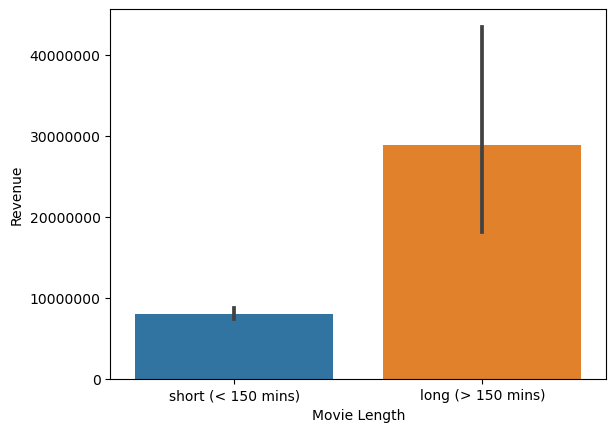

In [62]:
## group movie length (long vs Short) by revenue
# long movies
long_filter = df['runtime'] > 150.00
long_df = df[long_filter]
long_time = long_df['runtime']
# short movies
short_filter = df['runtime'] < 150.00
short_df = df[short_filter]
short_time = short_df['runtime']
## plot revenue of long vs short films
# Create a new categorical variable 'length' based on runtime
df['length'] = pd.cut(df['runtime'], bins=[0, 150, np.inf], labels=['short (< 150 mins)', 'long (> 150 mins)'])
sns.barplot(data=df, x='length', y='revenue')
plt.xlabel('Movie Length')
plt.ylabel('Revenue')
plt.ticklabel_format(style='plain', axis='y');


As shown on the plot, it seems that movies whose runtime are 150 minutes or more earn higher revenues than movies with less than 150 minutes of runtime. We will confirm this using a 2-Sample t-test.

## Check/remove outliers

In [66]:
# display revenue in long_time group
long_time_rev = long_df['revenue']
long_time_rev

6              0.0
267      2700000.0
273            0.0
279     42345360.0
417            0.0
           ...    
4418           0.0
4424           0.0
4425           0.0
4435           0.0
4564           0.0
Name: revenue, Length: 651, dtype: float64

In [70]:
# display revenue in short_time group 
short_time_rev = short_df['revenue']
short_time_rev

1               0.0
2               0.0
3               0.0
4               0.0
5       592461732.0
           ...     
4672            0.0
4673            0.0
4674            0.0
4675            0.0
4676            0.0
Name: revenue, Length: 35594, dtype: float64

In [68]:
# Check for outliers in long_time_rev group
zscores= stats.zscore(long_time_rev)
outliers = abs(zscores)>3
np.sum(outliers)

11

In [71]:
# Check for outliers in short_time_rev group
zscores= stats.zscore(short_time_rev)
outliers = abs(zscores)>3
np.sum(outliers)

384

In [72]:
# remove outliers from long_time_rev group
long_time_rev = long_time_rev[(np.abs(stats.zscore(long_time_rev)) < 3)]

In [73]:
# remove outliers from short_time_rev group
short_time_rev = short_time_rev[(np.abs(stats.zscore(short_time_rev)) < 3)]

## Check for Normality

In [74]:
# test the long_time_rev group for normality
result_long_time_rev = stats.normaltest(long_time_rev)
result_long_time_rev

NormaltestResult(statistic=830.29652201258, pvalue=5.051275701945429e-181)

In [75]:
# test the short_time_rev group for normality
result_short_time_rev = stats.normaltest(short_time_rev)
result_short_time_rev

NormaltestResult(statistic=47757.96346530998, pvalue=0.0)

Since the resulting p-values are below .05, the data is not normally distributed, but since the sample size is large enough, we can still continue.

## Check for equal variance

In [76]:
result = stats.levene(long_time_rev, short_time_rev)
result

LeveneResult(statistic=162.47626689592886, pvalue=3.920406654465869e-37)

## 2-Sample t-test

In [77]:
result = stats.ttest_ind(long_time_rev, short_time_rev, equal_var = False)
result

Ttest_indResult(statistic=4.291900422607449, pvalue=2.0452739840729665e-05)

Since the resulting p-value of the 2-sample t-test is less than our alpha of .05, can reject the null hypothesis and accept our alternative hypothesis that there is a significant difference in the revenues of long films (> 150 mins) versus short films (< 150 mins).  